<a href="https://colab.research.google.com/github/Jaspreetkhokhar12/Youtube_Comment_Analyzer/blob/main/PreProcessing_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Description**

This code snippet is the starting point for building a **YouTube Comment Analyzer Chrome Plugin**. It focuses on the preprocessing stage, where it loads a dataset containing Reddit comments and their associated sentiment categories. The goal of this phase is to prepare data for further processing, such as cleaning, vectorization, and model training for a **multiclass sentiment classification task**.

In [96]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [30]:
# Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/Jaspreetkhokhar12/Youtube_Comment_Analyzer/refs/heads/main/reddit_sentiment_analysis.csv')

# Displaying the first 5 rows
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


From the output above, we observe that the dataset includes a different sentiments as follow:

*   1 is for positive sentiment
*   0 is for neutral sentiment
*   -1 is for negative sentiment


## **Pre Processing**



In [31]:
# Checking the shape of the dataset: number of rows and columns
df.shape

(37249, 2)

In [32]:
# Randomly sampling a comment from the 'clean_comment' column
# This helps us understand how individual comments look
df.sample()['clean_comment'].values

array(['can you imagine other countries doing this how would you feel indian some flight the states chanted usa usa usa this sort nationalism unnerving '],
      dtype=object)

In [33]:
# Displaying summary info about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [34]:
# Checking for missing values in each column
df.isnull().sum()

,0
clean_comment,100
category,0


In [35]:
# Displaying rows with missing 'clean_comment' values
df[df['clean_comment'].isna()]

,clean_comment,category
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


This reveals the exact rows with NaN in the clean_comment column. Most of them are labeled as 0 (neutral), and should likely be removed before training a model.

In [36]:
# Count Categories for Missing Comments
df[df['clean_comment'].isna()]['category'].value_counts()

,count
category,
0,100


In [37]:
# Drop Rows with Missing Values
df.dropna(inplace=True)

In [38]:
# Check for Duplicate Rows
df[df.duplicated()]

,clean_comment,category
375,,0
392,,0
617,aurum mom,0
651,,0
1222,,0
...,...,...
36915,who won,0
37044,,0
37125,hari,0
37158,top kek,1


In [39]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [40]:
# verify removal of duplicates
df.duplicated().sum()

np.int64(0)

In [41]:
# Check empty or whitespace-only comments
df[(df['clean_comment'].str.strip() == '')]

,clean_comment,category
181,,0
4432,\n,0
10592,,0
16173,,0
32149,\n,0
34959,,0


We observed 6 rows that are empty strings or contain only whitespace ('\n'). These are not useful and should be removed.

In [42]:
# Filters out all rows where clean_comment is empty or whitespace after stripping
df = df[~(df['clean_comment'].str.strip() == '')]

In [43]:
# Convert the 'clean_comment' column to lowercase
df['clean_comment'] = df['clean_comment'].str.lower()

# Verify the transformation by displaying the first few rows
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [44]:
# Detect Comments With Leading or Trailing Spaces
df[df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))]

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37241,let the janta decide not ulema clerics,0
37242,hona hai same with vaccination education insu...,0
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [45]:
# Remove trailing and leading whitespaces from the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].str.strip()

# Verify the transformation by checking for any remaining trailing whitespaces
df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' ')).sum()

np.int64(0)

In [46]:
# Identify comments containing URLs
# Regex pattern explanation:
# - 'http[s]?://' matches 'http://' or 'https://'
# - The pattern continues with allowed URL characters (letters, digits, special characters)
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
comments_with_urls = df[df['clean_comment'].str.contains(url_pattern, regex=True)]


# Display the comments containing URLs
comments_with_urls.head()

,clean_comment,category


In [47]:
# Identify comments containing newline characters
comments_with_newline = df[df['clean_comment'].str.contains('\n')]

# Display a preview of the comments that contain newline characters
comments_with_newline.head()

,clean_comment,category
448,what missing jpg\nand why this brilliant edit ...,1
781,india has been ruined congress and populist sc...,-1
847,like aap for its stand corruption and making p...,-1
871,reduced trade\ndeficit stronger rupee aren the...,0
1354,amsa press conference australian maritime safe...,1


In [48]:
# Remove newline characters from the 'clean_comment' column
# Replace '\n' with a space to ensure proper formatting of the text
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)

# Verify that the transformation was successful by checking for any remaining newline characters
comments_with_newline_remaining = df[df['clean_comment'].str.contains('\n')]
comments_with_newline_remaining

,clean_comment,category


## **EDA**

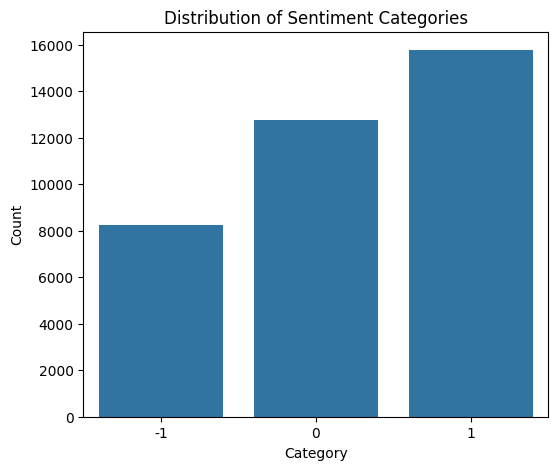

In [50]:
# Set plot size
plt.figure(figsize=(6, 5))

# Plotting the count of each sentiment category
sns.countplot(data=df, x="category")

# Add title and axis labels
plt.title("Distribution of Sentiment Categories")
plt.xlabel("Category")
plt.ylabel("Count")

# Show the plot
plt.show()

The bar plot illustrates the distribution of sentiment categories in the dataset which reveals a noticeable class imbalance. The majority of the comments are labeled as positive sentiment (1), followed by a considerable number of neutral (0) comments. In contrast, negative sentiment (-1) is underrepresented in comparison to the other two classes.

This imbalance may affect the performance of machine learning models, causing them to be biased toward predicting the dominant class (positive)

In [51]:
# Displaying the percentage distribution of each sentiment category
df['category'].value_counts(normalize=True).mul(100).round(2)

,proportion
category,
1,42.86
0,34.71
-1,22.42


In [52]:
# Add a new column 'word_count' that stores the number of words in each comment
# This is calculated by splitting each comment string on spaces and measuring the length of the resulting list
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))

In [53]:
df.sample(5)

,clean_comment,category,word_count
24641,first post article says note ban anniversary w...,-1,23
18230,modi has nothing with this these fringe groups...,1,22
25027,prasun bajpai abp news narendra modi read this...,-1,17
12024,think this lot the same lot the same lot the s...,0,50
21730,and bring back monarchy because they know they...,1,14


In [55]:
# Desc. Stats from word count
df['word_count'].describe()

,word_count
count,36793.000000
mean,29.667464
std,56.790738
min,1.000000
25%,6.000000
50%,13.000000
75%,30.000000
max,1307.000000


**Obervation:**

*   The average comment length is approximately 30 words, but the standard deviation is high (≈57), indicating a wide range in lengths.
*  50% of comments are 13 words or fewer, while 75% are 30 words or fewer, showing that most comments are relatively short.
* The minimum word count is 1, and the maximum is 1,307, suggesting the presence of a few very long comments, which are likely outliers.





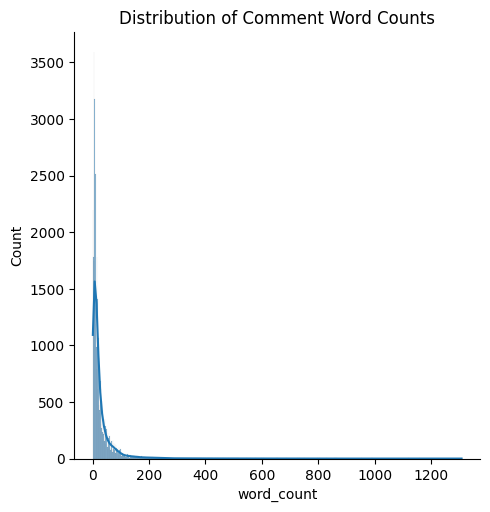

In [56]:
# Plotting the distribution of word counts in comments
# kde=True adds a smooth curve (Kernel Density Estimate) to visualize the distribution shape
# This helps in identifying skewness and concentration of values

sns.displot(df['word_count'], kde=True, height=5, aspect=1)

# Set titles and labels for clarity
plt.title('Distribution of Comment Word Counts')
plt.xlabel('word_count')
plt.ylabel('Count')

# Show the plot
plt.show()

**Observation:**

The histogram shows a right-skewed (positively skewed) distribution of word counts in the comments. Most comments are short, with the highest frequency occurring in the range of 5 to 20 words. As the word count increases, the frequency rapidly declines, with only a small number of comments exceeding 100 words.

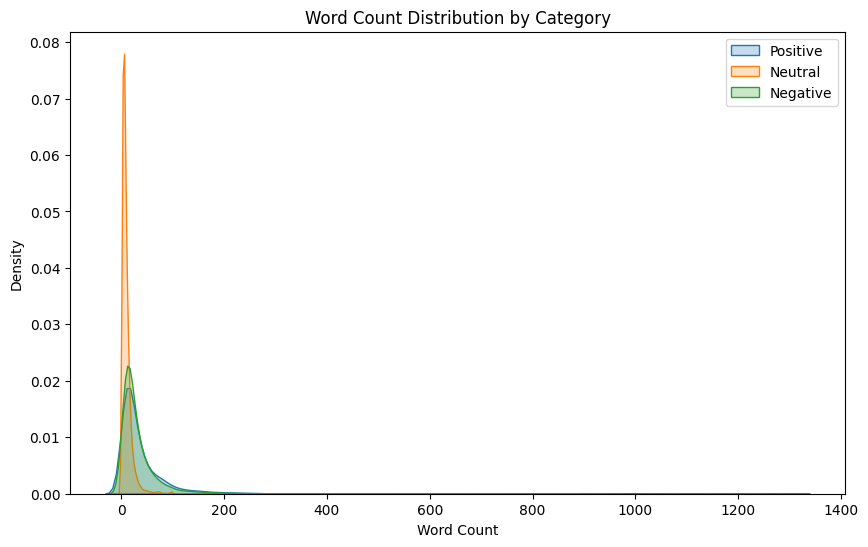

In [57]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['word_count'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['word_count'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['word_count'], label='Negative', fill=True)

# Add title and labels
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Observation:**

* **Positive comments (category 1)**: These tend to have a wider spread in word count, indicating that longer comments are more common in positive sentiments.<br>
* **Neutral comments (category 0)**: The distribution shows a relatively lower frequency and is more concentrated around shorter comments compared to positive or negative ones.<br>
* **Negative comments (category -1)**: These comments have a distribution somewhat similar to positive comments but with a smaller proportion of longer comments.

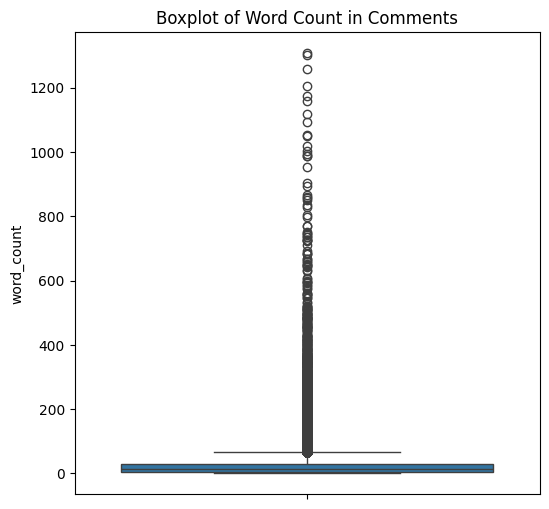

In [58]:
# Create a boxplot to visualize the distribution and detect outliers
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['word_count'])

# Add title and labels for clarity
plt.title("Boxplot of Word Count in Comments")
plt.ylabel("word_count")

# Display the plot
plt.show()


**Obervation:**

The boxplot clearly shows a highly skewed distribution of word counts. Most comments have a relatively low word count, as indicated by the compact interquartile range (IQR) near the bottom of the plot. However, there are a large number of outliers above the upper whisker, with word counts exceeding 100, 200, and even up to 1300 words.

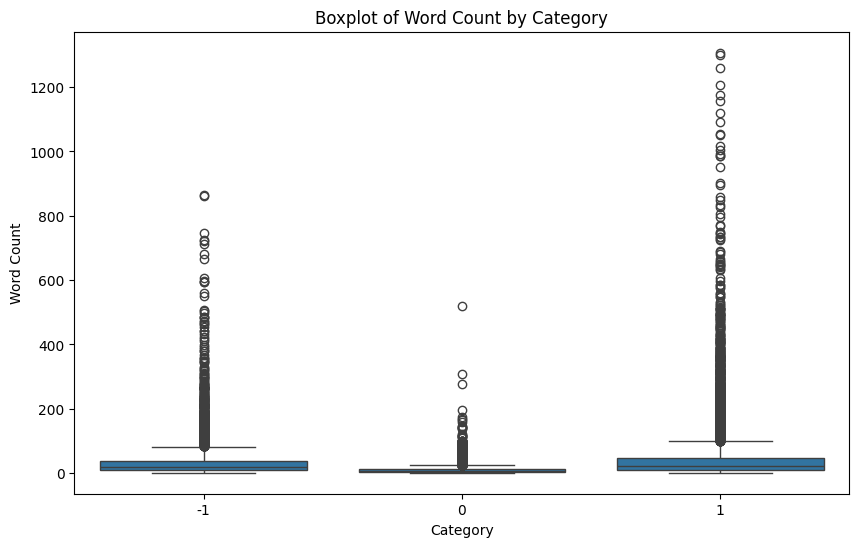

In [59]:
# Create a boxplot to compare word count distribution across sentiment categories
plt.figure(figsize=(10, 6))

# 'category' on x-axis and 'word_count' on y-axis to show distribution per class
sns.boxplot(data=df, x='category', y='word_count')

# Add chart title and axis labels
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')        # -1: Negative, 0: Neutral, 1: Positive
plt.ylabel('Word Count')

# Show the plot
plt.show()


**Observation:**

* **Positive comments (category 1)**: The median word count is relatively high, and there are several outliers with longer comments, indicating that positive comments tend to be more verbose.<br>
* **Neutral comments (category 0)**: The median word count is the lowest, with a tighter interquartile range (IQR), suggesting that neutral comments are generally shorter.<br>
* **Negative comments (category -1)**: The word count distribution is similar to positive comments but with a slightly lower median and fewer extreme outliers.

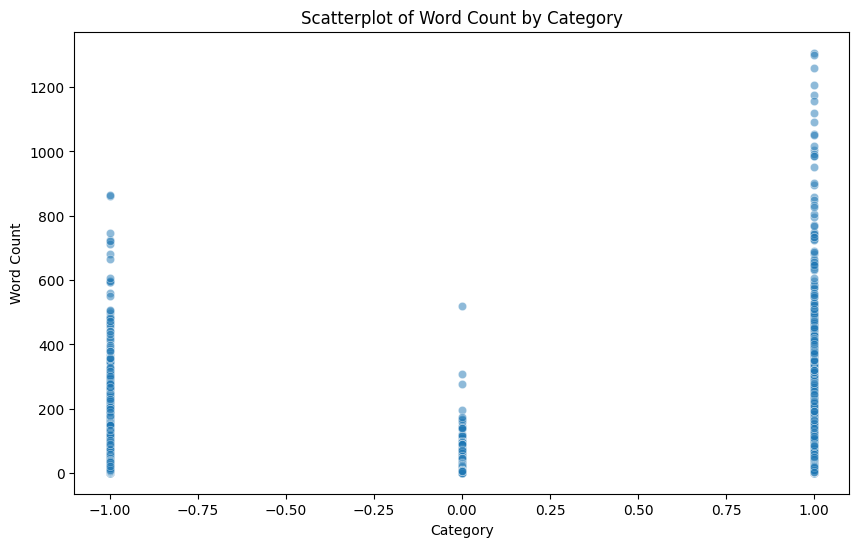

In [60]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a scatterplot to visualize the distribution of word counts across categories
# alpha=0.5 adds transparency to better see overlapping points
sns.scatterplot(data=df, x='category', y='word_count', alpha=0.5)

# Add title and axis labels
plt.title('Scatterplot of Word Count by Category')
plt.xlabel('Category')   # -1 = Negative, 0 = Neutral, 1 = Positive
plt.ylabel('Word Count')

# Show the plot
plt.show()

**Observation:**

This scatterplot visually confirms the presence of many outliers (extremely long comments) across all sentiment categories:

* The majority of comments in each category are clustered at lower word counts (under 100).

* Positive comments (category = 1) show the widest range in length, with numerous outliers reaching beyond 1000 words.

* Neutral comments (category = 0) tend to have shorter word counts with fewer extreme values.

* Negative comments (category = -1) have more variability than neutral but less than positive.

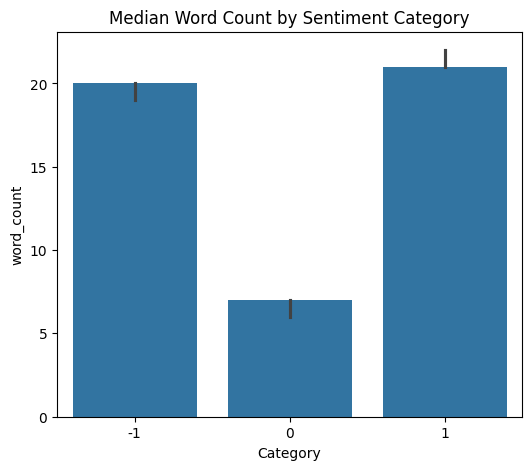

In [61]:
# Create a bar plot to visualize the median word count per sentiment category
plt.figure(figsize=(6, 5))

# Using estimator='median' to show median word count instead of the default mean
sns.barplot(df, x='category', y='word_count', estimator='median')

# Add title and axis labels
plt.title('Median Word Count by Sentiment Category')
plt.xlabel('Category')    # -1 = Negative, 0 = Neutral, 1 = Positive
plt.ylabel('word_count')

# Show the plot
plt.show()

**Observation:**

The bar plot reveals the median word count for each sentiment category:

* Positive comments (1) have the highest median word count, slightly above 21 words.

* Negative comments (-1) follow closely with a median of around 20 words.

* Neutral comments (0) stand out as being significantly shorter, with a median word count of only about 7 words.

This suggests that users expressing positive or negative sentiment tend to write longer, more detailed comments, while neutral comments are often brief and concise.

In [66]:
# Define the set of English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Create a new column 'num_stop_words' that stores the count of stopwords in each comment
# This is done by splitting the comment into words and checking how many are in the stopword list
df['num_stop_words'] = df['clean_comment'].apply(
    lambda x: len([word for word in x.split() if word in stop_words])
)

In [67]:
df.sample(5)

,clean_comment,category,word_count,num_stop_words
35950,they win they can,1,4,3
35880,perfect point where the job,1,5,2
10974,clean chit confirmed,1,3,0
9712,that logic shouldn really bother about the uri...,1,35,11
26687,celeste there too that wonderful,1,5,3


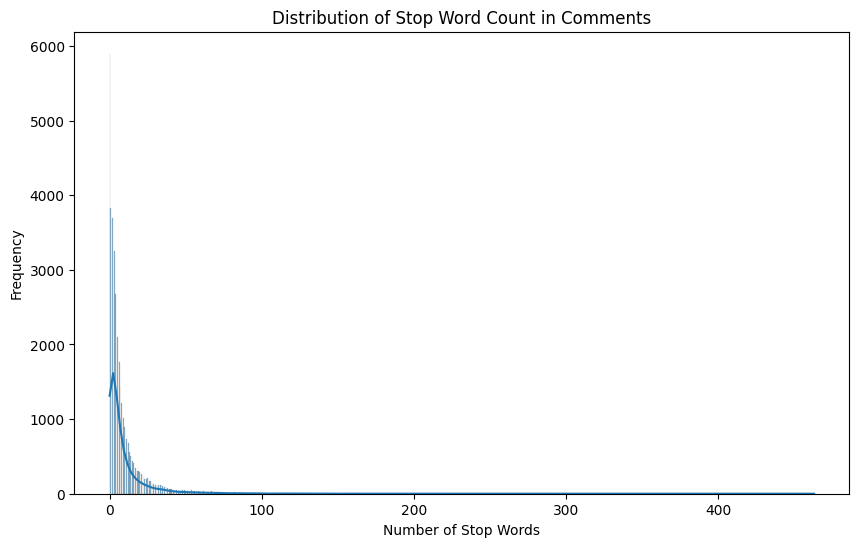

In [68]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Create a histogram + KDE for the number of stopwords in each comment
sns.histplot(df['num_stop_words'], kde=True)

# Add plot title and axis labels
plt.title('Distribution of Stop Word Count in Comments')
plt.xlabel('Number of Stop Words')
plt.ylabel('Frequency')

# Display the plot
plt.show()

**Observation:**

The distribution of stopword counts is heavily right-skewed:

* Most comments contain between 0 to 30 stopwords, with a sharp peak around 5–10.

* A long tail stretches out toward higher values, with a few comments containing over 400 stopwords, indicating extremely long or verbose entries.

* The KDE curve further confirms that the majority of comments are short in terms of stopword use, while only a few are heavily padded with them.



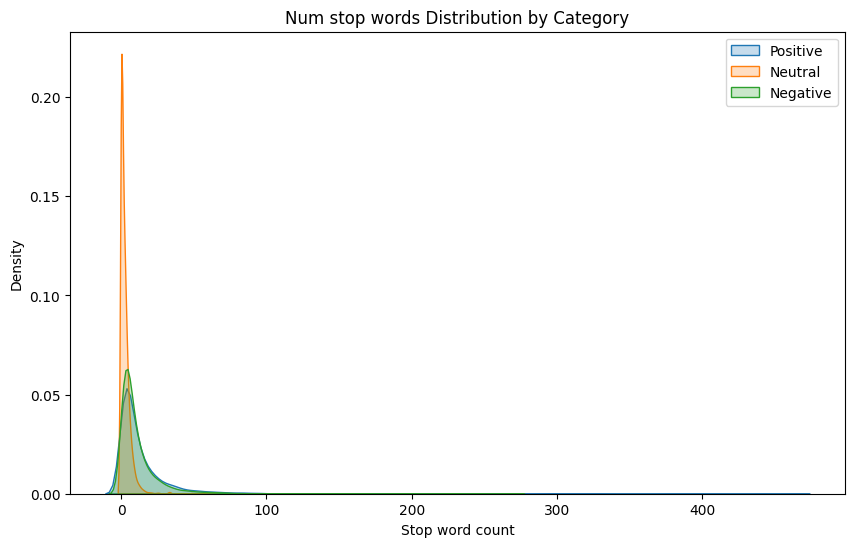

In [69]:
# Create the figure and set dimensions
plt.figure(figsize=(10, 6))

# KDE plot of stopword counts for Positive comments (category = 1)
sns.kdeplot(df[df['category'] == 1]['num_stop_words'], label='Positive', fill=True)

# KDE plot of stopword counts for Neutral comments (category = 0)
sns.kdeplot(df[df['category'] == 0]['num_stop_words'], label='Neutral', fill=True)

# KDE plot of stopword counts for Negative comments (category = -1)
sns.kdeplot(df[df['category'] == -1]['num_stop_words'], label='Negative', fill=True)

# Set the title and labels
plt.title('Num stop words Distribution by Category')
plt.xlabel('Stop word count')
plt.ylabel('Density')

# Show legend and display the plot
plt.legend()
plt.show()

**Observation:**

The KDE plot reveals distinct differences in stopword usage across sentiment categories:

* Neutral comments (orange curve) are tightly clustered near zero, indicating that they contain fewer stopwords overall. This aligns with earlier findings that neutral comments tend to be shorter and more concise.

* Positive and negative comments (blue and green curves) display broader distributions, suggesting they include a higher and more varied number of stopwords — consistent with their longer and more expressive nature.

* All three distributions are right-skewed, with a long tail of comments containing a large number of stopwords (especially for positive sentiment).

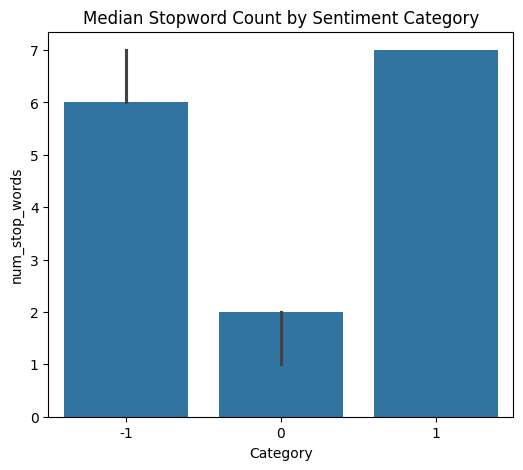

In [70]:
# Create a barplot showing the median number of stopwords in each sentiment category
plt.figure(figsize=(6, 5))
sns.barplot(df, x='category', y='num_stop_words', estimator='median')

# Set title and axis labels
plt.title('Median Stopword Count by Sentiment Category')
plt.xlabel('Category')  # -1 = Negative, 0 = Neutral, 1 = Positive
plt.ylabel('num_stop_words')

# Display the plot
plt.show()

**Observation:**

The bar plot illustrates the median number of stopwords used in comments across the three sentiment categories:

* Positive comments (category = 1) contain the highest median number of stopwords, around 7 words, indicating they are typically longer and more expressive.

* Negative comments (category = -1) follow closely behind, with a median of about 6 stopwords.

* Neutral comments (category = 0) have the lowest median, with only about 2 stopwords, reinforcing the earlier insight that these comments are generally shorter and more concise.

<ipython-input-73-1d854dd295ba>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')


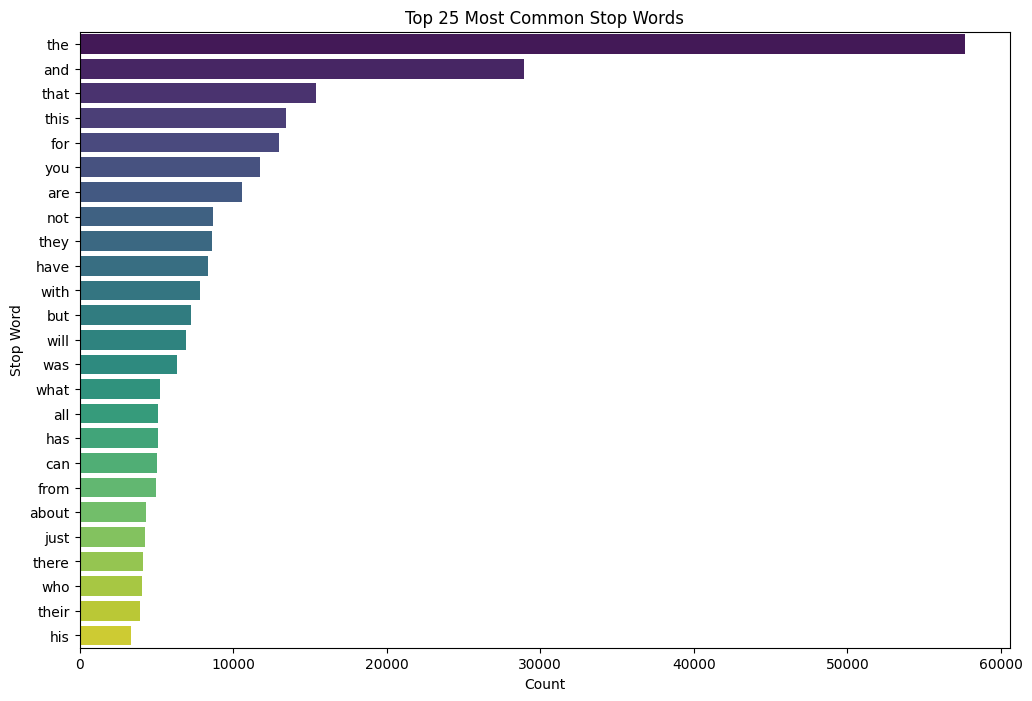

In [73]:
# Extract all stopwords from the 'clean_comment' column
# This flattens all comments into a single list of stopwords
all_stop_words = [word for comment in df['clean_comment'] for word in comment.split() if word in stop_words]

# Count the frequency of each stopword and get the top 25
most_common_stop_words = Counter(all_stop_words).most_common(25)

# Convert the result to a DataFrame for visualization
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

# Step 4: Create a horizontal bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')

# Add titles and axis labels
plt.title('Top 25 Most Common Stop Words')
plt.xlabel('Count')
plt.ylabel('Stop Word')

# Show the plot
plt.show()

In [74]:
# Create a new column 'num_chars' to store the number of characters in each comment
# This includes spaces and punctuation (if present in 'clean_comment')
df['num_chars'] = df['clean_comment'].apply(len)

# Display the first few rows to verify the new column
df.head()


,clean_comment,category,word_count,num_stop_words,num_chars
0,family mormon have never tried explain them th...,1,39,13,259
1,buddhism has very much lot compatible with chr...,1,196,59,1268
2,seriously don say thing first all they won get...,-1,86,40,459
3,what you have learned yours and only yours wha...,0,29,15,167
4,for your own benefit you may want read living ...,1,112,45,690


In [75]:
# Desc Stats of num_chars
df['num_chars'].describe()

,num_chars
count,36793.000000
mean,181.852798
std,359.702163
min,1.000000
25%,38.000000
50%,80.000000
75%,184.000000
max,8664.000000


**Observation:**

* The average comment length is about 182 characters, but the standard deviation is very high (≈360), indicating a wide range in text lengths.

* The median (80 characters) is much lower than the mean, confirming a right-skewed distribution — most comments are short, but a few are extremely long.

* The maximum length (8,664 characters) is unusually large and suggests outlier comments, possibly spam, copy-paste content, or multi-paragraph replies.

* 75% of comments are under 184 characters, meaning the vast majority are relatively brief.

In [78]:
# Combine all comments into one single large string
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character using Python's Counter
char_frequency = Counter(all_text)

# Convert the result to a DataFrame for easier viewing and sorting
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency'])


In [79]:
# View the characters
char_frequency_df['character'].values

array(['f', 'a', 'm', ..., 'ч', 'т', 'ю'], dtype=object)

In [81]:
# Display last 50 rows
char_frequency_df.tail(50)

,character,frequency
1328,妖,1
1329,婆,1
1330,段,1
1331,她,1
1332,谁,1
1333,抹,1
1334,掉,1
1335,坛,1
1336,回,1
1337,毫,1


In [82]:
# Create a new column 'num_punctuation_chars' to count punctuation marks in each comment
# The lambda function iterates through each character in the comment
# and counts it if it's in the specified list of common punctuation symbols

df['num_punctuation_chars'] = df['clean_comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)

# Display a sample of the updated DataFrame
df.sample(5)

,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
30168,the end each goverments run there should somet...,1,21,7,127,0
11695,why not surprised art teacher,-1,5,2,29,0
25995,how congress winning people forgot years gener...,1,14,3,89,0
5034,all those whatsapp sharing sucked all jpeg fro...,0,11,5,63,0
27821,the terrorist attacks your country are your co...,1,18,7,126,0


In [83]:
df['num_punctuation_chars'].describe()

,num_punctuation_chars
count,36793.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


<ipython-input-85-7b521e97869e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


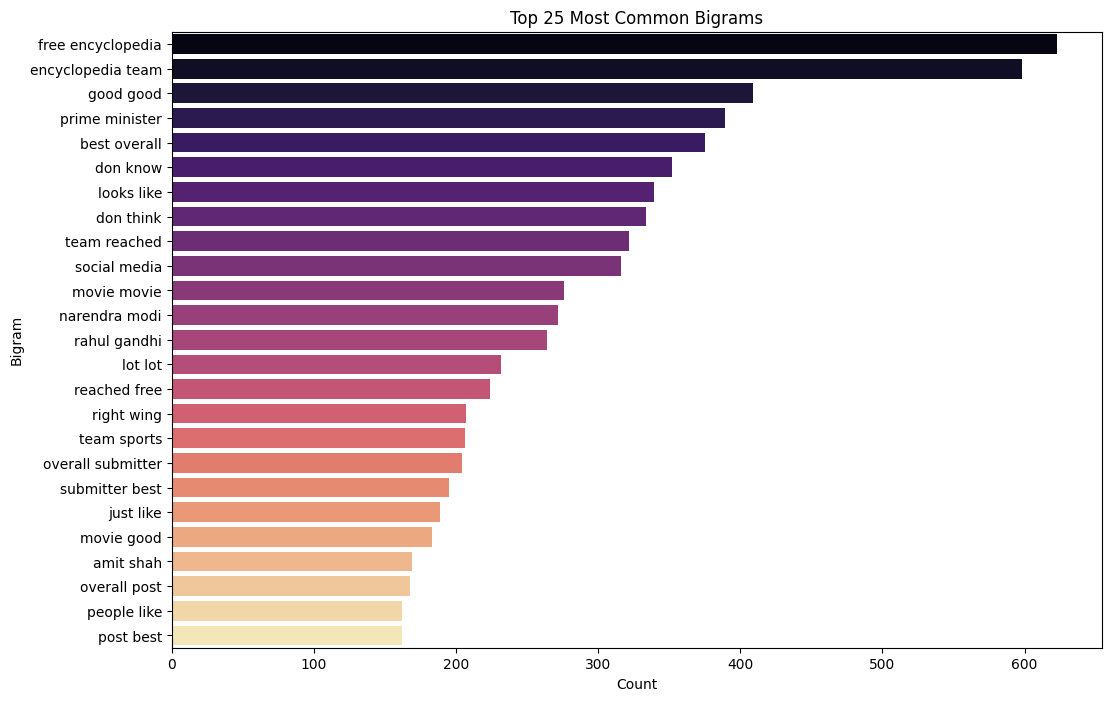

In [85]:
# Function to extract the most common bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 25 bigrams
top_25_bigrams = get_top_ngrams(df['clean_comment'], 25)

# Convert to DataFrame for visualization
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()


<ipython-input-86-fbc0c48f1656>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


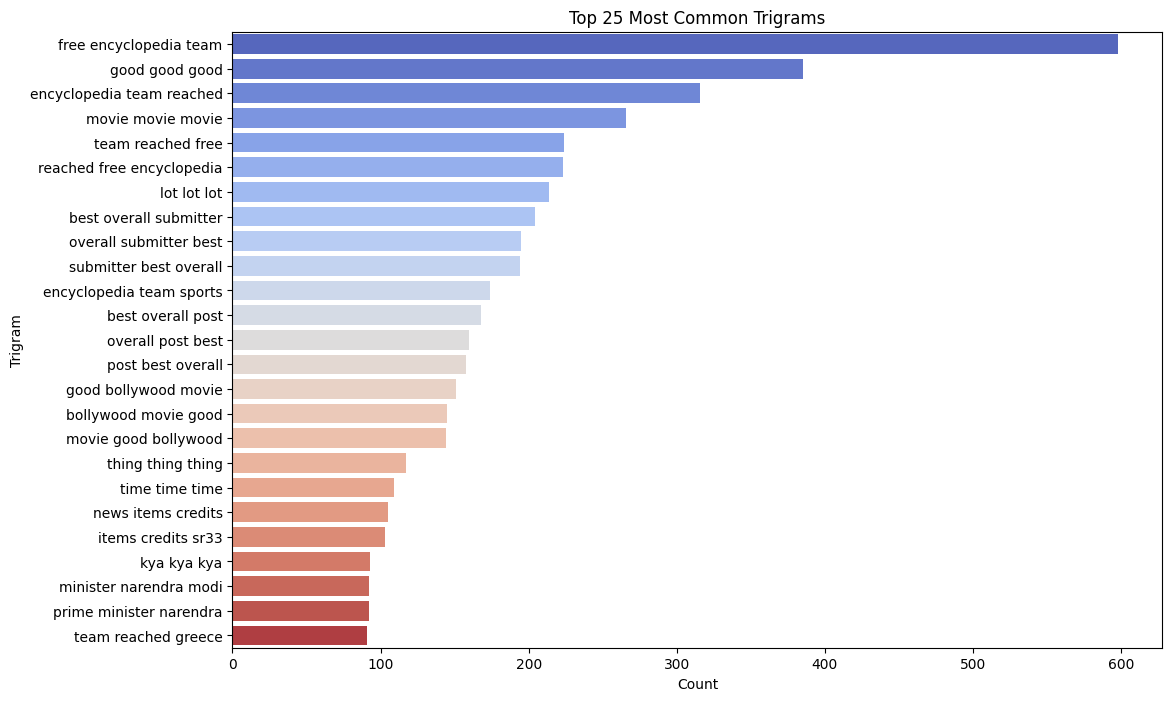

In [86]:
def get_top_trigrams(corpus, n=None):
    # Create a CountVectorizer to extract trigrams and ignore English stopwords
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)

    # Transform the corpus into a bag-of-words sparse matrix
    bag_of_words = vec.transform(corpus)

    # Sum up the total frequency for each trigram
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of (trigram, frequency) tuples
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort the list by frequency in descending order
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]  # Return the top N trigrams

# Extract top 25 trigrams
top_25_trigrams = get_top_trigrams(df['clean_comment'], 25)

# Convert to DataFrame for visualization
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()


In [89]:
# Remove all characters except:
# - Uppercase A–Z
# - Lowercase a–z
# - Digits 0–9
# - Whitespace (\s)
# - Common punctuation: ! ? . ,

df['clean_comment'] = df['clean_comment'].apply(
    lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x))
)


In [90]:
# Combine all comments into a single large string
# This allows us to count character usage across the entire dataset
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character in the combined text
# Counter will create a dictionary with each character as a key and its count as the value
char_frequency = Counter(all_text)

# Convert the character-frequency dictionary into a DataFrame
# Each row will represent a character and its frequency
char_frequency_df = pd.DataFrame(
    char_frequency.items(),
    columns=['character', 'frequency']
)

# Sort the DataFrame by frequency in descending order
# This helps in identifying the most common characters at the top
char_frequency_df = char_frequency_df.sort_values(by='frequency', ascending=False)

# Display the sorted DataFrame
char_frequency_df


,character,frequency
6,,1091592
12,e,666610
13,t,491287
1,a,481134
3,i,401388
9,n,388465
7,o,379908
17,s,355279
8,r,331425
10,h,296748


In [91]:
df.head()

,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
0,family mormon have never tried explain them th...,1,39,13,259,0
1,buddhism has very much lot compatible with chr...,1,196,59,1268,0
2,seriously don say thing first all they won get...,-1,86,40,459,0
3,what you have learned yours and only yours wha...,0,29,15,167,0
4,for your own benefit you may want read living ...,1,112,45,690,0


In [92]:
# Define standard English stopwords, but exclude words that are important for sentiment
# These exceptions help preserve negation or contrast (e.g., "not good" vs "good")
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Apply stop word removal to each comment in the 'clean_comment' column
# Only retain words that are NOT in the stop word list (excluding the custom exceptions)
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)


In [95]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to each word in the 'clean_comment' column
# This transforms each word to its base/dictionary form (e.g., "running" → "run")
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

# Display the first few rows to verify changes
df.head()

,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0


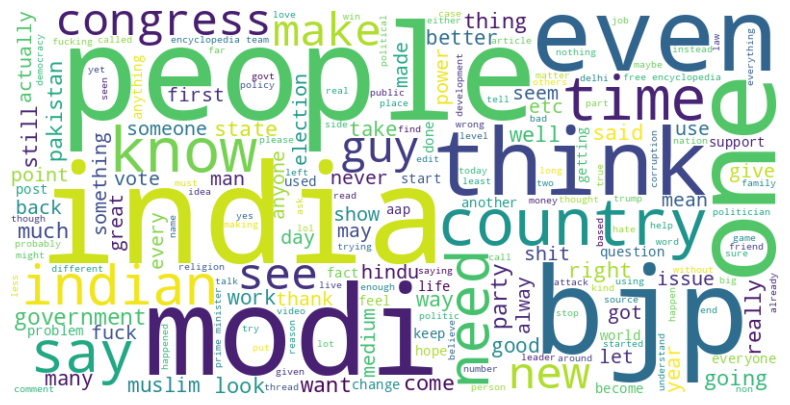

In [97]:
# Define a function to generate and plot a word cloud
def plot_word_cloud(text):
    # Step 1: Combine all comments into a single string for the word cloud
    all_text = ' '.join(text)

    # Step 2: Generate a word cloud object from the combined text
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white'
    ).generate(all_text)

    # Step 3: Plot the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')  # Smooth rendering
    plt.axis("off")  # Hide axes for a clean look
    plt.show()

# Call the function on the 'clean_comment' column
plot_word_cloud(df['clean_comment'])

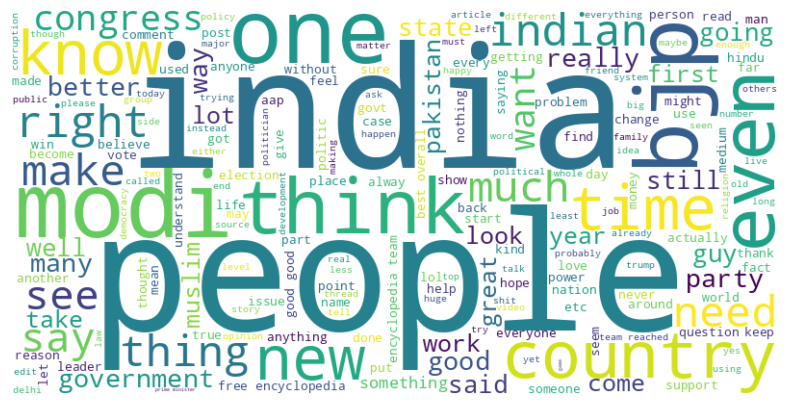

In [98]:
# Function to generate and display a word cloud
def plot_word_cloud(text):
    # Combine all text entries into a single string
    wordcloud = WordCloud(
        width=800, height=400, background_color='white'
    ).generate(' '.join(text))

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')  # Smooth rendering
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

# Generate a word cloud for comments labeled as Positive (category = 1)
plot_word_cloud(df[df['category'] == 1]['clean_comment'])

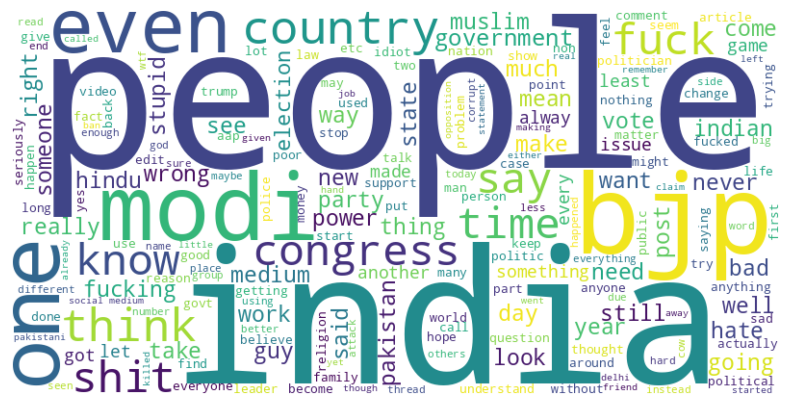

In [99]:
plot_word_cloud(df[df['category'] == -1]['clean_comment'])  # Negative

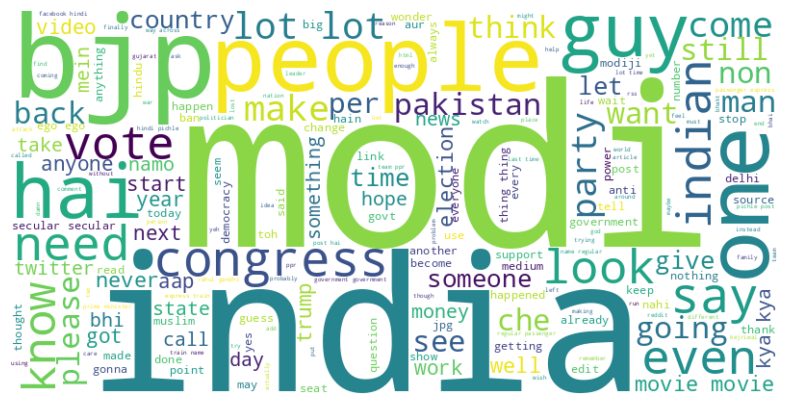

In [100]:
plot_word_cloud(df[df['category'] == 0]['clean_comment'])   # Neutral

<ipython-input-101-58cc98fec5bf>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


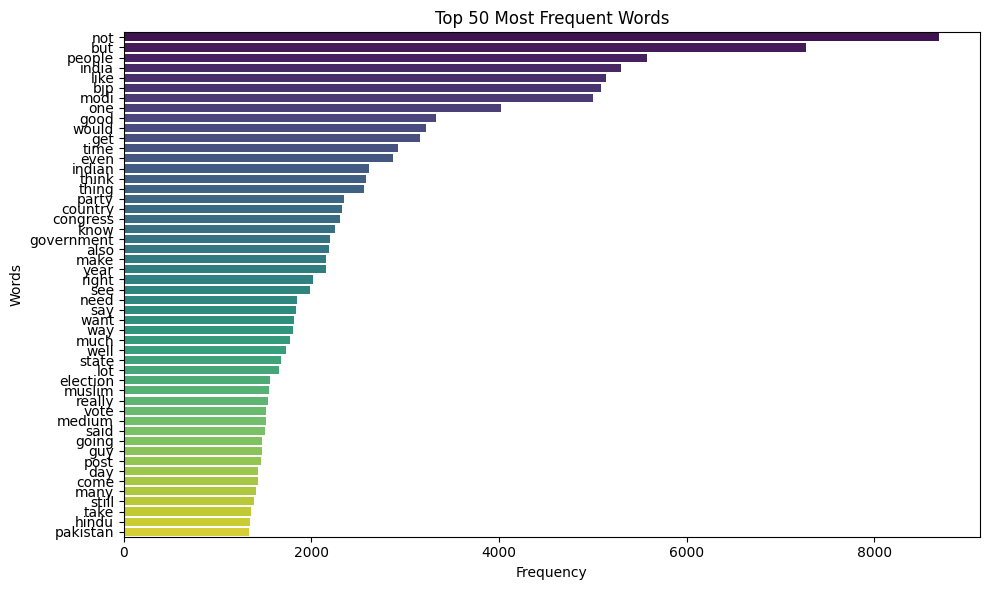

In [101]:
# Function to plot the top N most frequent words in 'clean_comment'
def plot_top_n_words(df, n=20):
    """Plot the top N most frequent words in the dataset."""

    # Step 1: Flatten all words from the 'clean_comment' column into a single list
    words = ' '.join(df['clean_comment']).split()

    # Step 2: Count word frequencies using Counter
    counter = Counter(words)
    most_common_words = counter.most_common(n)

    # Step 3: Separate words and counts for plotting
    words, counts = zip(*most_common_words)

    # Step 4: Create a horizontal bar plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")

    # Step 5: Customize plot appearance
    plt.title(f'Top {n} Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

# Example usage
plot_top_n_words(df, n=50)
